<a href="https://colab.research.google.com/github/maragraziani/intro-interpretableAI/blob/main/L2A1_Lucid_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 2: Assignment 1
## Feature visualization with the Lucid Toolbox

**Created by:**
- Mara Graziani
    - PhD student at Hes-so Valais & University of Geneva
    - mara.graziani@hevs.ch  
    
#### Content
* [Introduction](#intro)
* [Installation & Data](#Section0)
* [Exercise 1](#Section1)
* [Exercise 2](#Section2)

#### Take-away messages

* Generates synthetic images (starting from random pixel values) that cause a maximal activation of a neuron or a channel
* Realistic-looking outputs are difficult to obtain
* Risk of generating "fooling" examples or adversarial images.


Credits: 

Great part of the exercises in this notebook were taken and adapted from https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb of Copyright 2018 Google LLC, Licensed under the Apache License, Version 2.0 (the "License");
The original notebooks provided in the repo are still coded in Python 2.7.

If you want to expand your experiments further you are strongly encouraged to visit the main repo: https://github.com/tensorflow/lucid

In [1]:
!python --version

Python 2.7.17


In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction

[**Lucid**](https://github.com/tensorflow/lucid) is a framework for visualizing neural networks. 

The basic idea behind lucid is that of Activation Maximization (AM) introduced in 2009 by Erhan, Bengio and others [1]. Extending the previous work on Deep Dream visualizations [2], Lucid allows to optimize, through gradient ascent, the activations of a unit or a channel of a Convolutional Neural Network (CNN).

Gradient ascent is performed with an update rule such as:

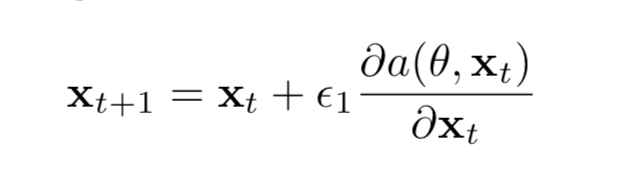

where x_(t+1) is an iterative step obtained by following the gradient of the activation a(θ,x_t) given the network parameters θ of a step size ε1.  
Gradient ascent is essentially a very similar algorithm to that of gradient descent used for training the CNN initially. Note, however, that in this case the network parameters are frozen, so are not updated. x is the only variable being updated. The initial starting point for x is typically a random image. 

### Fooling examples
AM is, in practice, the synthetization of an image. In a high dimensional space such an optimization may not always converge to visualization that make sense. *Rubbish* or *fooling* examples [3] are patterns of high-frequency noise that are not representative of any patter in particular but that highly activate a unit. 

<figure class="image">
  <img src="https://images.deepai.org/converted-papers/1904.08939/x2.png" width="400">
</figure>
Image credits [4].  

### Introducing priors in the optimization objective
A regularization term R(x) can be introduced in the optimization objective to constrain the search to look more natural-like or realistic. 
A basic approach encourages the smoothness of the generated images by computing a total variation loss (TV) on the entire image. 
Another approach is that of introducing a regularization operator r that can be, for example, a Gaussian blur kernel. 

This sligtly modifies the update step in the equation above into 

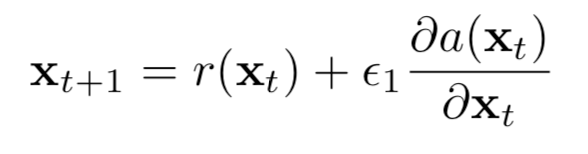

Several regularizers were proposed. To understand the experiments in this tutorial, you should keep in mind the main idea of each regularizer, described in the list below. For a deeper review on AM and local statistics you should consider reading Chapter 4 of [4].

*   intensity penalization by α-norm, e.g. L2 regularization: it avoids images with saturated pixel values
*   high-frequency penalization: smoothing by total variation loss or Gaussian blurring
* Jitter, rotation and scaling applied before each update. This transformation step prior to the update encourages the synthetization of images that are robust to transformations
* Encourage realistic color synthesis by matching colors from real data 



### References 

[1]Erhan, D., Bengio, Y., Courville, A., Vincent, P.: Visualizing higher-layer features of a deep network. Dept. IRO, Universit ́e de Montr ́eal, Technical report 4323 (2009)

[2]Mordvintsev, A., Olah, C., Tyka, M.: Inceptionism: going deeper into neural net- works. Google Research Blog (2015).

[3]Nguyen, A., Yosinski, J., Clune, J.: Deep neural networks are easily fooled: high confidence predictions for unrecognizable images. In: Proceedings of the IEEE Computer Vision and Pattern Recognition (CVPR), pp. 427–436 (2015)

[4]Samek, W., Montavon, G., Vedaldi, A., Hansen, L.K. and Müller, K.R. eds., 2019. *Explainable AI: interpreting, explaining and visualizing deep learning* (Vol. 11700). Springer Nature.

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.sandbox.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


## Install, Import, Load Model

In [2]:
# Expanded modelzoo is only available as of lucid v0.3
!pip install --quiet lucid==0.3
#tensorflow_version only works in colab
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('1')

from lucid.misc.io import show, load
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

     |████████████████████████████████| 51kB 6.7MB/s 
TensorFlow 1.x selected.


### Using the model zoo

The techniques in this notebook were developed to experiment on multiple models.The **Lucid modelzoo** is a list of available pre-compiled models that you can use easily for the experiments. You can find below the list of models. 

### List of available models as of 19/05/2021:
Below you can find an updated list of the models that are available in the Lucid model zoo and how to access them. 

'AlexNet', \\
 'AlexNet_caffe_Places365', \\
 'CaffeNet_caffe', \\
 'InceptionResnetV2_slim', \\
 'InceptionV1', \\
 'InceptionV1_caffe', \\
 'InceptionV1_caffe_Places205', \\
 'InceptionV1_caffe_Places365', \\
 'InceptionV1_slim', \\
 'InceptionV2_slim', \\
 'InceptionV3_slim', \\
 'InceptionV4_slim', \\
 'MobilenetV1_025_slim', \\
 'MobilenetV1_050_slim', \\
 'MobilenetV1_slim', \\
 'NasnetLarge_slim', \\
 'NasnetMobile_slim', \\
 'PnasnetLarge_slim', \\
 'PnasnetMobile_slim', \\
 'ResnetV1_101_slim', \\
 'ResnetV1_152_slim', \\
 'ResnetV1_50_slim', \\
 'ResnetV2_101_slim', \\
 'ResnetV2_152_slim', \\
 'ResnetV2_50_slim', \\
 'VGG16_caffe', \\
 'VGG19_caffe', 

Let us now pick a model from the modelzoo:


In [3]:
import lucid.modelzoo.vision_models as models

In [4]:
# Let's import a model from the Lucid modelzoo!

model = models.InceptionV3_slim()
model.load_graphdef()

W0519 11:43:31.235956 139713160730496 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:62: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0519 11:43:31.237745 139713160730496 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:70: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0519 11:43:32.563313 139713160730496 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/modelzoo/util.py:38: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [15]:
model.layers

[{'name': 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu',
  'size': 32,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu',
  'size': 32,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu',
  'size': 64,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu',
  'size': 80,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu',
  'size': 192,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Mixed_5b/concat',
  'size': 256,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Mixed_5c/concat',
  'size': 288,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Mixed_5d/concat',
  'size': 288,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Mixed_6a/concat',
  'size': 768,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Mixed_6b/concat',
  'size': 768,
  'type': 'conv'},
 {'name': 'InceptionV3/InceptionV3/Mixed_6c/concat',
  'size': 768,
  'type': 'conv'},
 {'name': 'InceptionV3/Inception

We will be working with InceptionV3. Above you can find the layers list. 

## Visualize a Neuron

W0519 11:43:41.091382 139713160730496 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:88: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0519 11:43:42.646634 139713160730496 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/param/spatial.py:54: The name tf.spectral.irfft2d is deprecated. Please use tf.signal.irfft2d instead.

W0519 11:43:42.660482 139713160730496 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:223: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0519 11:43:42.662333 139713160730496 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:241: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0519 11:43:42.663870 139713160730496 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/

512 2.2616506



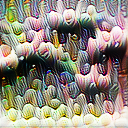

In [6]:

layer_name='InceptionV3/InceptionV3/Mixed_5b/concat'
neuron = 100
# Note: You can check the size of the layer in the layers list above
visualize_command='{}:{}'.format(layer_name, neuron)
_ = render.render_vis(model, visualize_command)

# Visualize a neuron by an explicit objective

512 2.5107079



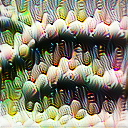

In [21]:
obj = objectives.channel("InceptionV3/InceptionV3/Mixed_5b/concat", 100)
_ = render.render_vis(model, obj)
# The channel name corresponds to the layer name

Adding **transformation** robustness through jitter:  

512 3.6330905



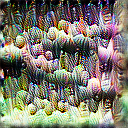

In [22]:
transforms = [
    transform.jitter(2)
]
_ = render.render_vis(model, obj, transforms=transforms)

Adding scaling, random rotations and so on:

512 2.4214604



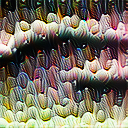

In [23]:
transforms = [
    transform.pad(16),
    transform.jitter(8),
    transform.random_scale([n/100. for n in range(80, 120)]),
    transform.random_rotate(range(-10,10) + range(-5,5) + 10*range(-2,2)),
    transform.jitter(2)
]
_ = render.render_vis(model, obj, transforms=transforms)

Visualizing more layers, more neurons:


512 8.549585



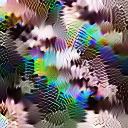

In [24]:
obj=objectives.channel("InceptionV3/InceptionV3/Mixed_5d/concat", 20)
_ = render.render_vis(model, obj, transforms=transforms)

512 6.3632827



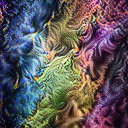

In [25]:
obj=objectives.channel("InceptionV3/InceptionV3/Mixed_6e/concat", 45)
_ = render.render_vis(model, obj, transforms=transforms)

512 17.295252



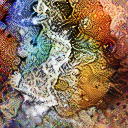

In [26]:
obj=objectives.channel("InceptionV3/InceptionV3/Mixed_7b/concat", 200)
_ = render.render_vis(model, obj, transforms=transforms)

**Assignment**: Choose a network from the model zoo and visualize arbitrary neurons from all layer depths. What can you see, infer? How does changing the transformations affect your results? 

**Optional**: Expand this analysis to another model. Can you compare the feature visualizations of the two models? What are eventual analogies/differences?

**Recomended reading**: The Feature Visualization article's section titled [The Enemy of Feature Visualization](https://distill.pub/2017/feature-visualization/#enemy-of-feature-vis) discusion of "Transformation Robustness." In particular, there's an interactive diagram that allows you to easily explore how different kinds of transformation robustness effects visualizations.

# Preconditioning and parametrization

Let us add a further condition that will make the data decorrelated and whitened. The options in the following cells will make the Lucid toolbox perform the gradient descent in the Fourier basis, where the frequences are scaled so that they all have equal energy. 

512 19.563185



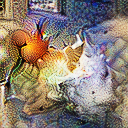

In [30]:
# selecting one image
layer_name="InceptionV3/InceptionV3/Mixed_7b/concat"
neuron=200
# Visualization without preconditioning
obj=objectives.channel(layer_name, neuron)
_ = render.render_vis(model, obj, transforms=transforms)

512 22.101768



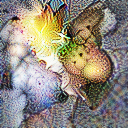

In [28]:
# Visualization with decorrelation 
param_f = lambda: param.image(128, fft=True, decorrelate=True)
_ = render.render_vis(model, obj, param_f)

512 14.866533



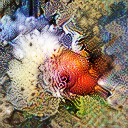

In [31]:
# Adding feature robustness 
param_f = lambda: param.image(128, fft=True, decorrelate=True)
transforms = [
    transform.pad(16),
    transform.jitter(8),
    transform.random_scale([n/100. for n in range(80, 120)]),
    transform.random_rotate(range(-10,10) + range(-5,5) + 10*range(-2,2)),
    transform.jitter(2)
]
obj = obj=objectives.channel(layer_name, neuron) 
_ = render.render_vis(model, obj, transforms=transforms, param_f=param_f)

512 164.36562



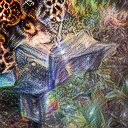

In [33]:
# Adding feature L2 regularization 
param_f = lambda: param.image(128, fft=True, decorrelate=True)

obj = obj=objectives.channel(layer_name, neuron) + objectives.L2(layer=layer_name)
_ = render.render_vis(model, obj, transforms=transforms, param_f=param_f)

512 17.83487



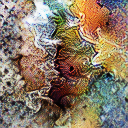

In [35]:

obj = obj=objectives.channel(layer_name, neuron) + objectives.diversity(layer=layer_name)
_ = render.render_vis(model, obj, transforms=transforms, param_f=param_f)

In [36]:
dir(objectives)

['L1',
 'L2',
 'Objective',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__warningregistry__',
 '_dot',
 '_dot_cossim',
 '_make_arg_str',
 '_tf_blur',
 'absolute_import',
 'alignment',
 'as_objective',
 'blur_alpha_each_step',
 'blur_input_each_step',
 'channel',
 'channel_interpolate',
 'class_logit',
 'decorator',
 'deepdream',
 'direction',
 'direction_cossim',
 'direction_neuron',
 'diversity',
 'division',
 'input_diff',
 'neuron',
 'np',
 'penalize_boundary_complexity',
 'print_function',
 'tf',
 'total_variation',
 'wrap_objective']

**Assignment**: experiment with other regularization functions provided in the Lucid toolbox. You can find these by running the dir(objectives) command in the cell above. What are these regularization types? What do they do? (hint: to visualize some information about a functions you can run objectives.<function_name\>?)

# Visualizing more than a single neuron

Adding two or more neurons:


512 18.595497



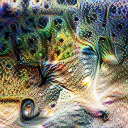

In [13]:
layer_name='InceptionV3/InceptionV3/Mixed_6e/concat'
channel = lambda n: objectives.channel(layer_name, n)
param_f = lambda: param.image(128, fft=True, decorrelate=True)
transforms = [
    transform.pad(16),
    transform.jitter(8),
    transform.random_scale([n/100. for n in range(80, 120)]),
    transform.random_rotate(range(-10,10) + range(-5,5) + 10*range(-2,2)),
    transform.jitter(2)
]
obj = channel(210) + channel(212)
_ = render.render_vis(model, obj, transforms=transforms, param_f=param_f)

512 60.61069



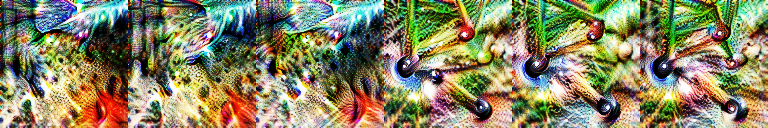

In [17]:
#Interpolating neurons
def interpolate_param_f():
  unique = param.fft_image((6, 128, 128, 3))
  shared = [
    param.lowres_tensor((6, 128, 128, 3), (1, 128//2, 128//2, 3)),
    param.lowres_tensor((6, 128, 128, 3), (1, 128//4, 128//4, 3)),
    param.lowres_tensor((6, 128, 128, 3), (1, 128//8, 128//8, 3)),
    param.lowres_tensor((6, 128, 128, 3), (2, 128//8, 128//8, 3)),
    param.lowres_tensor((6, 128, 128, 3), (1, 128//16, 128//16, 3)),
    param.lowres_tensor((6, 128, 128, 3), (2, 128//16, 128//16, 3)),
  ]
  return param.to_valid_rgb(unique + sum(shared), decorrelate=True)

obj = objectives.channel_interpolate(layer_name, 210, layer_name, 212)

_ = render.render_vis(model, obj, interpolate_param_f)

512 1.8298995



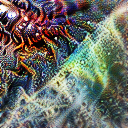

In [40]:
# Visualize an entire layer:
layer = 'InceptionV3/InceptionV3/Mixed_6e/concat'
# Adding feature robustness 
param_f = lambda: param.image(128, fft=True, decorrelate=True)

obj = objectives.deepdream(layer)
_ = render.render_vis(model, obj,param_f=param_f)

512 8.061944



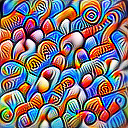

In [39]:
layer = 'InceptionV3/InceptionV3/Mixed_5b/concat'
obj = objectives.deepdream(layer)
_ = render.render_vis(model, obj)

512 7.019296



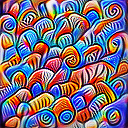

In [41]:
layer = 'InceptionV3/InceptionV3/Mixed_5b/concat'
obj = objectives.deepdream(layer)
_ = render.render_vis(model, obj, param_f=param_f)

Read more: https://distill.pub/2018/differentiable-parameterizations/
